<a href="https://colab.research.google.com/github/danielsaggau/deep_unsupervised_learning/blob/master/pieces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Delorean:

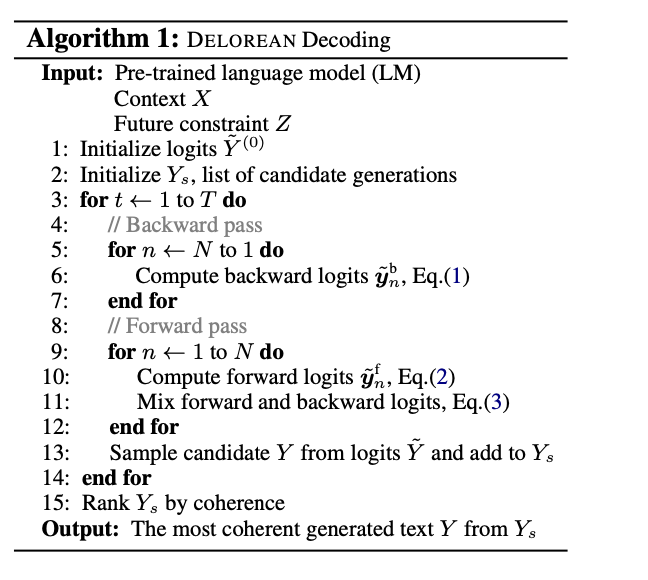

In [ ]:
"""
Rank counterfactual candidates with BERT
"""
import os
import argparse
import json
from difflib import SequenceMatcher

import numpy as np
import tqdm

import torch
from transformers import BertForNextSentencePrediction, BertTokenizer
BIG_CONST = 1e10


Reference: https://arxiv.org/pdf/1909.11942v6.pdf

BERT (Devlin et al., 2019) uses a **loss based on predicting whether the second segment in a pair has been swapped with a segment from another document.** We compare to this loss in our experiments and find that **sentence ordering** is a more challenging pretraining task and more useful for certain downstream tasks.


Alternative: MegatronBert

This is the only reasonable huggingface next sentence prediction task left *italicized text*

In [ ]:
# from transformers import MegatronBertForNextSentencePrediction

Alternative: Albert

To further improve the performance of ALBERT, we also introduce a self-supervised loss for sentence-order prediction (SOP). SOP primary focuses on inter-sentence coherence and is designed to address the ineffectiveness (Yang et al., 2019; Liu et al., 2019) of the next sentence prediction (NSP) loss proposed in the original BERT.


**Long version**
ALBERT uses a pretraining loss based on **predicting the ordering of two consecutive segments of text**. Several researchers have experimented with pretraining objectives that similarly relate to discourse coherence. Coherence and cohesion in discourse have been widely studied and many phenomena have been identified that connect neighboring text segments (Hobbs, 1979; Halliday & Hasan, 1976; Grosz et al., 1995). Most objectives found effective in practice are quite simple. Skip- thought (Kiros et al., 2015) and FastSent (Hill et al., 2016) sentence embeddings are learned by using an encoding of a sentence to predict words in neighboring sentences. Other objectives for sentence embedding learning include predicting future sentences rather than only neighbors (Gan et al., 2017) and predicting explicit discourse markers (Jernite et al., 2017; Nie et al., 2019).** Our loss is most similar to the sentence ordering objective of Jernite et al. (2017),** where sentence embeddings are learned in order to determine the ordering of two consecutive sentences. Unlike most of the above work, however, our loss is defined on** textual segments rather than sentences.** 
Concurrently to our work, Wang et al. (2019) also **try to predict the order of two consecutive segments of text, but they combine it with the original next sentence prediction in a three-way classification task rather than empirically comparing the two.**

In [ ]:
#from transformers import AlbertForSequenceClassification,AlbertTokenizer

Alternative: DeBert-a

**Huggingface summary:**
It builds on RoBERTa with disentangled attention and enhanced mask decoder training with half of the data used in RoBERTa.


https://arxiv.org/pdf/2006.03654.pdf

**Original Paper Contribution:**
The first is the disentangled attention mechanism, where each word is represented using two vectors that encode its content and position, respectively, and the attention weights among words are computed using disen- tangled matrices on their contents and relative positions, respectively. Second, an enhanced mask decoder is used to incorporate absolute positions in the de- coding layer to predict the masked tokens in model pre-training.


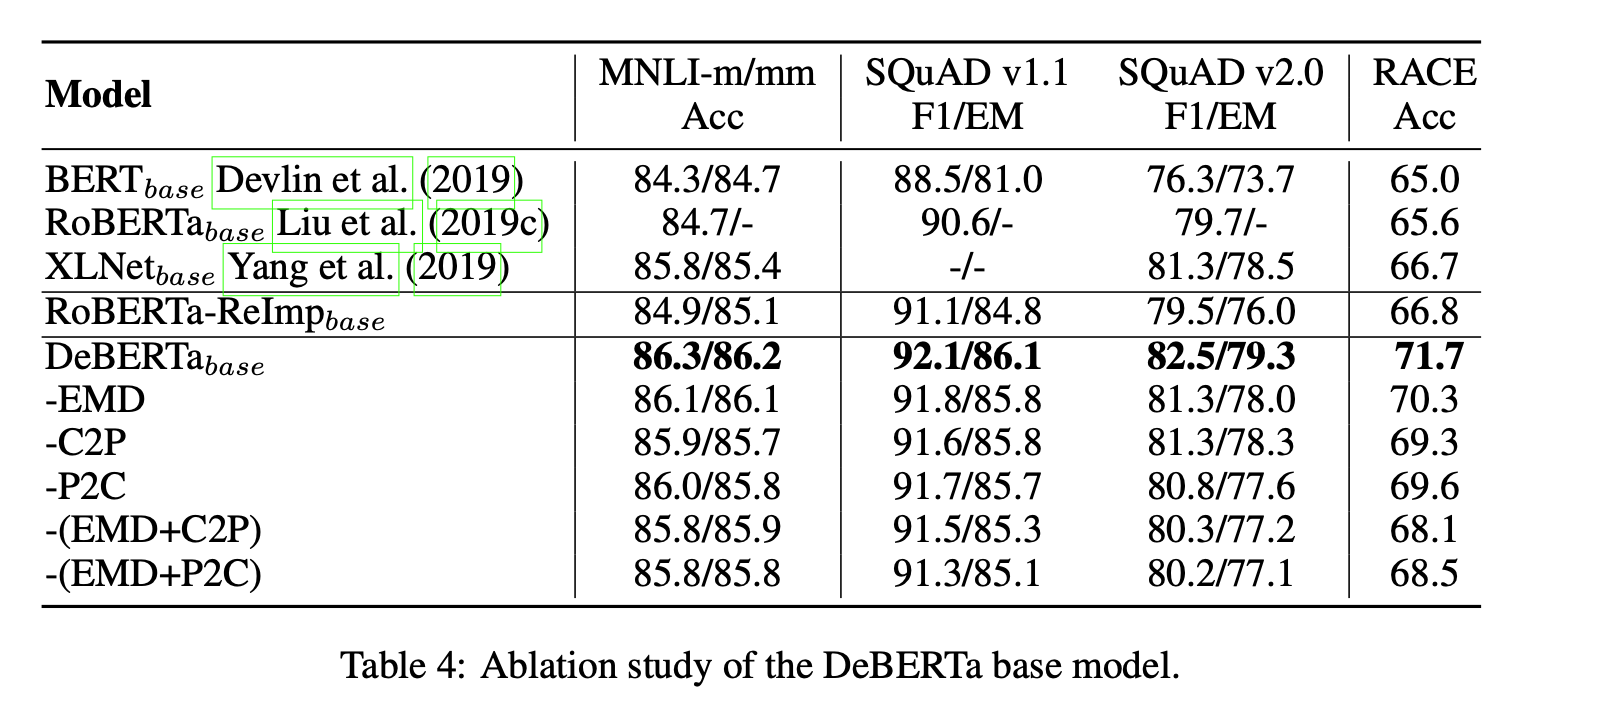

In [ ]:
#from transformers import DebertaTokenizer, DebertaForMaskedLM
#import torch
#tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
#model = DebertaForMaskedLM.from_pretrained('microsoft/deberta-base')

In [ ]:
def read_original_data(fname, num_lines=-1):
    """
    Read original data. Only read premise + counterfactual
    as keys.
    """
    data = []
    with open(fname, 'r') as fr:
        lines = fr.readlines()
        for i, line in enumerate(lines):

            if i == num_lines:
                break

            line = line.strip()
            line = json.loads(line)

            data.append(' '.join([line['premise'], line['counterfactual']]))

    print('Original data size: ', len(data))

    return data

In [ ]:
def read_hyps_from_json_counterfactual(fname, num_lines=-1, hyps_dict=None):
    """
    Read counterfactual reasoning hypotheses.

    Since each counterfactual instance was splitted into 3 segments because the
    story ending contains 3 sentences (see Appendix A.2 in the paper for more
    details), this reading function will concatenate the 3 segments together to
    obtain a complete instance.
    
    Example:
    
    "counterfactual": "We are Washingtonians and rooted for the Seahawks.", 
    "original_ending": "In the final seconds I was looking at the floor depressed. 
    I was shocked and happy when my wife said the Patriots intercepted. 
    It was a great moment in Boston sports."}
    """
    if num_lines > 0:
        assert num_lines % 3 == 0

    if hyps_dict is None:
        hyps_dict = {}

    print("Reading ", fname)

    with open(fname, 'r') as fr:
        lines = fr.readlines()
        assert len(lines) % 3 == 0 or len(lines) > num_lines

        for i in range(len(lines) // 3):

            if i == num_lines // 3:
                break

            orig = []
            hyps = []
            for j in range(3):
                line = json.loads(lines[i*3+j])

                if j == 0:
                    # Use premise + counterfactual as the key
                    k = line["premise"] + ' ' + line["counterfactual"]
                    if k not in hyps_dict:
                        dict_k = {}
                        dict_k["premise"] = line["premise"].strip()
                        dict_k["initial"] = line["initial"].strip()
                        dict_k["counterfactual"] = line["counterfactual"].strip()
                        dict_k["original_ending"] = line["original_ending"].strip()
                        dict_k["hyps_str"] = {} # for replacing repeat entries
                        dict_k["hyps"] = []
                        dict_k["orig"] = []
                        hyps_dict[k] = dict_k
                    else:
                        dict_k = hyps_dict[k]

                orig_j = line["original_ending_so_far"][len(". "):].strip()
                orig.append(orig_j)

                hyps_j = line["H_Candidates"][-1].strip()
                hyps.append(hyps_j)

            # Replace repeat entries
            hyps_str = ' '.join(hyps).strip()
            if hyps_str in dict_k["hyps_str"]:
                hyps = ['DEPRECATED', '', '']
            else:
                dict_k["hyps_str"][hyps_str] = 1

            dict_k["hyps"].append(hyps)
            dict_k["orig"].append(orig)

    return hyps_dict


In [ ]:
def is_deprecated(hyp):
    return hyp[0] == 'DEPRECATED'


def _has_repeat_sent(hyp):
    """
    Detect if the sentences in `hyp` are repeat.

    Args:
        hyp: A list of three sentences.
    """
    if len(hyp) <= 1:
        return False

    for i in range(1, len(hyp)):
        a = hyp[i-1]
        b = hyp[i]

        if a == b:
            return True

        s = SequenceMatcher(None, a, b)
        if len(a) > 5 and len(b) > 5 and s.ratio() >= 0.85:
            return True

    return False


def _has_repeat_substring(s, MINLEN=5, MINCNT=4):
    d = {}
    has_repeat = False
    for sublen in range(int(len(s)/MINCNT)-1, MINLEN-1, -1):
        for i in range(0, len(s)-sublen):
            sub = s[i:i+sublen]
            if len(sub.strip()) < sublen:
                continue
            cnt = s.count(sub)
            if cnt >= MINCNT and sub not in d:
                 d[sub] = cnt
                 has_repeat = True
                 break
        if has_repeat:
            break
    return has_repeat


def has_repeat(hyp):
    """
    Detect if the hypothesis text has repeat patterns.
    """
    has_repeat_substring = False
    for h in hyp:
        has_repeat_substring = has_repeat_substring or _has_repeat_substring(h)
    return has_repeat_substring or _has_repeat_sent(hyp)


NSP Loss



Meaning of the scores: 

1.    its com- patibility with the subsequent text of the context X
2.   the internal consistency of Y if it consists of multiple sentences
3. the compatibility of Y with its right-side text when it is applicable

In [ ]:
def _get_bert_score(x, y, model, tokenizer, device='cuda'):
    encoded = tokenizer.encode_plus(x, text_pair=y, return_tensors='pt')
    for k in encoded:
        encoded[k] = encoded[k].to(device)
    seq_relationship_logits = model(**encoded)[0]
    return seq_relationship_logits[0, 0].tolist()


def rank_by_bert(ins, model, tokenizer, device='cuda'):
    scores = []
    for hyp in ins['hyps']:

        if is_deprecated(hyp) or has_repeat(hyp):
            # If the hypothesis has obvious repeat text, then
            # discard it by setting the ranking scores to -1.
            s = [-1] * 3
            scores.append(s)
            continue

        o1_h1_score = _get_bert_score(
            ins['premise'] + ' ' + ins['counterfactual'],
            hyp[0],
            model=model, tokenizer=tokenizer, device=device)

        o1_h123_score = _get_bert_score(
            ins['premise'] + ' ' + ins['counterfactual'],
            ' '.join(hyp),
            model=model, tokenizer=tokenizer, device=device)

        h1_h2_score = _get_bert_score(
            hyp[0], hyp[1],
            model=model, tokenizer=tokenizer, device=device)
        h2_h3_score = _get_bert_score(
            hyp[1], hyp[2],
            model=model, tokenizer=tokenizer, device=device)
        avg_consec_score = np.mean([o1_h1_score, h1_h2_score, h2_h3_score])

        s = [o1_h1_score, o1_h123_score, avg_consec_score]

        scores.append(s)

    return scores


In [ ]:
def get_best_hyp(ins, scores):
    # Rank by avg_consec_scores
    acs = [s[2] for s in scores]
    acs_ranked_indexes = sorted(range(len(acs)), key=lambda k: acs[k])
    acs_ranked_indexes.reverse()
    # Pick top K and rank by o1_h123
    K = 2
    o1_h123_scores = [scores[i][1] for i in acs_ranked_indexes[:K]]
    best_o1_h123_scores_index = o1_h123_scores.index(max(o1_h123_scores))
    best_index = acs_ranked_indexes[best_o1_h123_scores_index]

    best_score = scores[best_index][2]
    if best_score == -1:
        return None
    else:
        return ins["hyps"][best_index]


In [ ]:
def main():
    parser = argparse.ArgumentParser()

    parser.add_argument("--hyps_dir", type=str, default='./',
                        help="Input dir, which contains josn files of hypotheses to be ranked.")
    parser.add_argument("--hyps_num_lines", type=int, default=-1,
                        help="The number of lines to be processed in the hypotheses files."
                             "For counterfactual reasoning, this number should be a multiple of 3.")
    parser.add_argument("--output_dir", type=str, default='./outputs', help="Output dir")
    parser.add_argument("--no_cuda", action="store_true", help="no cuda")
    parser.add_argument("--align_to_original_data", action="store_true",
                        help="Whether to align the output to the original input data.")
    parser.add_argument("--original_data_file", type=str, default='../data/counterfactual/small_data.json',
                        help="Filename of the original input data for counterfactual reasoning.")
    parser.add_argument("--original_num_lines", type=int, default=-1,
                        help="The number of lines (instances) to be read from the original data file.")

    args = parser.parse_args()

    # Set the device
    device = "cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu"

    def _maybe_create_dir(dirname):
        """Creates directory if doesn't exist
        """
        if not os.path.isdir(dirname):
            os.makedirs(dirname)
            return True
        return False

    output_dir = args.output_dir
    _maybe_create_dir(output_dir)

    # Read hypotheses
    if os.path.isfile(args.hyps_dir):
        fnames = [args.hyps_dir]
    else:
        fnames = []
        for f in os.listdir(args.hyps_dir):
            fname = os.path.join(args.hyps_dir, f)
            if os.path.isfile(fname) and fname.endswith('.json'):
                fnames.append(fname)

    hyps_dict = None
    for fname in fnames:
        hyps_dict = read_hyps_from_json_counterfactual(
            fname, num_lines=args.hyps_num_lines, hyps_dict=hyps_dict)

    if args.align_to_original_data:
        original_data = read_original_data(args.original_data_file, num_lines=args.original_num_lines)
        assert len(original_data) == len(hyps_dict)

    # Load pretrained model
    model = BertForNextSentencePrediction.from_pretrained('bert-base-cased') # change
    model.to(device)
    model.eval()
    tokenizer = BertTokenizer.from_pretrained('bert-base-cased') # change 

    # Rank
    scores_dict = {}
    for key, ins in tqdm.tqdm(hyps_dict.items()):
        bert_scores = rank_by_bert(ins, model, tokenizer, device=device)
        scores_dict[key] = bert_scores

    # Output ranking scores
    with open(output_dir + "/scores.tsv", "w") as fout:

        fout.write('\t'.join(["premise", "initial", "counterfactual", "original_ending",
                              "generated_ending", "bert_o1h1", "bert_o1h123", "bert_consec"]) + '\n')

        def _write_ins(key, ins):
            """Write the scores of an instance."""
            for i, hyp in enumerate(ins["hyps"]):
                gen_ending = ' '.join(hyp).strip()
                s = scores_dict[key][i]
                fout.write('\t'.join([ins["premise"], ins["initial"], ins["counterfactual"],
                                      ins["original_ending"], gen_ending] +
                                     [str(s_) for s_ in s]))
                fout.write('\n')

        if args.align_to_original_data:
            for key in original_data:
                ins = hyps_dict[key]
                _write_ins(key, ins)
        else:
            for key, ins in hyps_dict.items():
                _write_ins(key, ins)


    if args.align_to_original_data:
        # Print ranked results
        with open(output_dir + "/ranked_samples.tsv", "w") as fo_rank:

            fo_rank.write('\t'.join(["premise", "initial", "counterfactual", "original_ending",
                                     "ranked_generated_ending"]) + '\n')

            for key in original_data:
                ins = hyps_dict[key]

                best_hyp = get_best_hyp(ins, scores_dict[key])
                if best_hyp is None:
                    # If all hyps are deprecated, then use the original ending
                    gen_ending = ins["original_ending"]
                else:
                    gen_ending = ' '.join(best_hyp).strip()

                fo_rank.write('\t'.join([ins["premise"], ins["initial"], ins["counterfactual"],
                                        ins["original_ending"], gen_ending]))
                fo_rank.write('\n')


if __name__ == "__main__":
    main()

Table: 


